# Basic imports

In [ ]:
import re
import pdfplumber
from spacy.lang.nb import Norwegian
import spacy

# Helper functions

In [80]:
def pdfToText(fileName):
    all_text = ""
    with pdfplumber.open(fileName) as pdf:
        for page in pdf.pages:
            all_text += page.extract_text()
    # print(all_text)
    all_text = re.sub('\s', ' ', all_text)
    # print(all_text)
    return all_text

regPlan = pdfToText('regional-planstrategi-2016-2010.pdf')
kirkepol = pdfToText('050200-sak-kommunens-kirkepolitikk.pdf')
smabathavn = pdfToText('kommunedelplan-for-smabathavner-2007-2017.pdf')
kultur = pdfToText('strategiplan-kultur-web.pdf')
havbruk = pdfToText("havbruk.pdf")

In [ ]:
def txtToStr(filename):
    f = open(filename, 'r')
    textLines = f.readlines()
    text = ""
    for line in textLines:
        text += line
    text = re.sub('\s', ' ', text)
    return text

brautTxt = txtToStr("braut.txt")
byplanWiki = txtToStr("byplanleggingWiki.txt")

# Scraping

No need to run if "sdg#.txt" in "sdgs" folder is present.

In [ ]:
# Scraping imports and inits
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
driver = webdriver.Chrome(ChromeDriverManager().install())
from bs4 import BeautifulSoup as BS

In [ ]:
# Scraping sdgs from FN.
sdgs = []
driver.get("https://www.fn.no/om-fn/fns-baerekraftsmaal")
soup = BS(driver.page_source, features="html.parser")
title_cards = soup.find_all(class_="header_gols_content_item")
for card in title_cards:
    a = card.find("a", href=True)
    sdgs.append(a["href"])
print(sdgs)
i = 1
for sdg in sdgs:
    driver.get(f"https://www.fn.no/{sdg}")
    soup = BS(driver.page_source, features="html.parser")
    paragraphs = soup.find_all("p")
    f = open(f'sdgs/sdg{i}.txt', 'w')
    for par in paragraphs:
        line = par.text.strip()
        line = line.replace('...', '')
        line = line.replace('&aelig;', 'æ')
        if len(line) > 0:
            if not line[-1] in ".?!:)":
                line += '.'
            f.write(f'{line}\n')
    f.close()
    i += 1

# Predicting

In [ ]:
def similarityText(mainStr, searchStr):
    """
    Return spacy similatiry based on vector in nb_core_news_lg.
    """
    nlp = spacy.load("nb_core_news_lg")

    mainDoc = nlp(mainStr)
    searchDoc = nlp(searchStr)

    mainTokenized = nlp(' '.join([str(token.lemma_) for token in mainDoc if not token.is_stop and not token.is_punct and not token.is_space]))
    searchTokenized = nlp(' '.join([str(token.lemma_) for token in searchDoc if not token.is_stop and not token.is_punct and not token.is_space]))
    # print(mainTokenized)
    # print(searchTokenized)
    return mainTokenized.similarity(searchTokenized)

In [ ]:
def sdgSimilatiry(string):
    """
    Print and return similarity of string to all SDGs.
    """
    valueList = []
    for sdg in range(17):
        value = similarityText(string, txtToStr(f"sdgs/sdg{sdg+1}.txt"))
        print(f"SDG #{sdg+1} has this similarity to your string: {value}")
        valueList.append(value)
    return valueList

In [ ]:
def addSdgVector(str, name):
    """
    Add similarity results to sdgVector.
    """
    return sdgSimilatiry(str)

In [ ]:
# for documentation see: https://www.kaggle.com/satishgunjal/tutorial-text-classification-using-spacy
import string
nlp = spacy.load("nb_core_news_lg")
parser = Norwegian()
punctuations = string.punctuation
stop_words = spacy.lang.nb.stop_words.STOP_WORDS
def spacy_tokenizer(sentence):
    """This function will accepts a sentence as input and processes the sentence into tokens, performing lemmatization, 
    lowercasing, removing stop words and punctuations."""
    
    # Creating our token object which is used to create documents with linguistic annotations
    mytokens = nlp(sentence)
    
    # lemmatizing each token and converting each token in lower case
    # Note that spaCy uses '-PRON-' as lemma for all personal pronouns lkike me, I etc
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    
    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations]
    # Return preprocessed list of tokens
    return mytokens  

In [ ]:
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline

In [ ]:
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        """Override the transform method to clean text"""
        return [clean_text(text) for text in X]
    
    def fit(self, X, y= None, **fit_params):
        return self
    
    def get_params(self, deep= True):
        return {}

# Basic function to clean the text
def clean_text(text):
    """Removing spaces and converting the text into lowercase"""
    return text.strip().lower()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfVector = TfidfVectorizer(tokenizer=spacy_tokenizer)

In [ ]:
# Creating trainingdata for classifying SDGs
X_train = []
y_train = []
for i in range(17):
    f = open(f'sdgs/sdg{i+1}.txt')
    for line in f:
        line = re.sub('\s', ' ', line)
        X_train.append(line)
        y_train.append(i+1)

In [67]:
from sklearn.linear_model import LogisticRegression

# Create pipeline using Tf-idf
pipe = Pipeline ([("cleaner", predictors()),
                 ("vectorizer", tfidfVector),
                 ("classifier", LogisticRegression(multi_class='ovr', solver='liblinear'))])
                 

In [68]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('cleaner', <__main__.predictors object at 0x7fbfbef84b90>),
                ('vectorizer',
                 TfidfVectorizer(tokenizer=<function spacy_tokenizer at 0x7fbfa4f0b950>)),
                ('classifier',
                 LogisticRegression(multi_class='ovr', solver='liblinear'))])

In [113]:
X_test = [kirkepol, regPlan, kultur, havbruk]

In [119]:
def tfidfModel(trainingData, testData):
    """
    Return predicted probabilities for Pipeline (pipe).
    """
    pipe = Pipeline ([("cleaner", predictors()),
                 ("vectorizer", tfidfVector),
                 ("classifier", LogisticRegression(multi_class='ovr', solver='liblinear'))])

    pipe.fit(trainingData[0], trainingData[1])

    predicted = pipe.predict_proba(testData)
    return predicted

In [22]:
import wikiscraper as ws


In [31]:
ws.lang("no")


In [46]:
abstractList = []
with open("randWiki.txt", "a") as file:
    for i in range(1000):
        result = ws.searchBySlug("Spesial:Tilfeldig")
        try:
            abstractList = result.getAbstract()
            for par in abstractList:
                if not "[rediger | rediger kilde]" in par:
                    file.write(par + "\n")
        except:
            pass

In [47]:
X_train2 = []
y_train2 = []
for i in range(17):
    with open(f'sdgs/sdg{i+1}.txt', 'r') as f:
        for line in f:
            line = re.sub('\s', ' ', line)
            X_train2.append(line)
            y_train2.append(0)

with open('randWiki.txt', 'r') as f:
    for line in f:
        line = re.sub('\s', ' ', line)
        X_train2.append(line)
        y_train2.append(1)


Pipeline(steps=[('cleaner', <__main__.predictors object at 0x7fbfb02f1d50>),
                ('vectorizer',
                 TfidfVectorizer(tokenizer=<function spacy_tokenizer at 0x7fbfa4f0b950>)),
                ('classifier',
                 LogisticRegression(multi_class='ovr', solver='liblinear'))])

In [115]:
baerBool = tfidfModel([X_train2, y_train2], X_test)
sdgPredictions = tfidfModel([X_train, y_train], X_test)


In [116]:
sdgPredictions = sdgPredictions*17
print(sdgPredictions)

[[0.84913867 0.93554681 1.01185746 0.8091974  1.05742576 0.87502345
  0.97693799 0.99242396 0.9127674  1.22725544 1.27713014 0.97227971
  0.82904171 0.92952645 1.03969889 1.1077071  1.19704167]
 [0.80216301 0.95960833 0.96217811 0.90166694 0.87938053 0.76404125
  0.95078693 0.90410536 1.34755515 0.94615066 1.14509438 1.13569871
  0.88179046 0.99372032 0.94929748 0.87439644 1.60236593]
 [0.83641834 0.87694283 0.94442731 0.83200358 0.763254   0.8172398
  0.75318819 1.08785113 1.45563175 0.9891339  1.12402005 1.02154812
  0.75300147 0.93690809 1.11039561 1.13946505 1.55857078]
 [0.6582105  0.75909168 0.82325174 0.59281402 0.54445987 0.85080172
  0.62420197 0.54462318 0.73359203 0.75159353 0.71857841 0.82519623
  0.99968466 4.25946192 1.64791939 0.76348058 0.90303854]]


In [117]:
for i in range(len(sdgPredictions)):
    sdgPredictions[i] = sdgPredictions[i]*baerBool[i][0]
print(sdgPredictions)
    

[[0.32765071 0.36099237 0.39043778 0.31223888 0.40802088 0.33763868
  0.37696367 0.38293912 0.35220265 0.47355177 0.49279654 0.37516621
  0.31989605 0.35866934 0.40118074 0.42742256 0.46189341]
 [0.76735672 0.91797039 0.92042867 0.86254311 0.84122372 0.73088908
  0.90953175 0.86487573 1.28908399 0.90509666 1.0954081  1.08642012
  0.84352908 0.95060224 0.90810694 0.8364559  1.53283839]
 [0.62755589 0.65796098 0.70859388 0.62424354 0.57266144 0.61316642
  0.56510918 0.81620326 1.09214519 0.74213676 0.84334042 0.76645681
  0.56496908 0.70295228 0.83311815 0.85492864 1.16937927]
 [0.6582105  0.75909168 0.82325174 0.59281402 0.54445987 0.85080172
  0.62420197 0.54462318 0.73359203 0.75159353 0.71857841 0.82519623
  0.99968466 4.25946192 1.64791939 0.76348058 0.90303854]]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


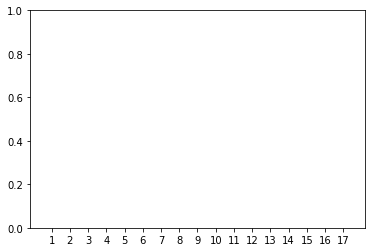

[0, 0.5898519682401577, 0.6021433343193712, 0.3127155545558697, 0.20611858989332438, 0, 0.5476587703758374, 0.32437862546244095, 1, 0.5254833119548625, 1, 1, 0.2176453988218025, 0.7530112067685526, 0.5405346970555537, 0.18227948264484709, 1]


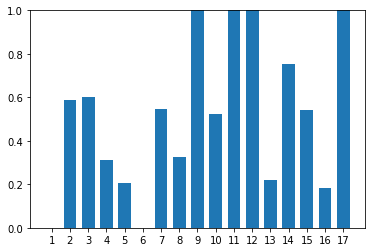

[0, 0, 0, 0, 0, 0, 0, 0.0810162949724741, 1, 0, 0.2167020905158124, 0, 0, 0, 0.16559074469339521, 0.2746431889566187, 1]


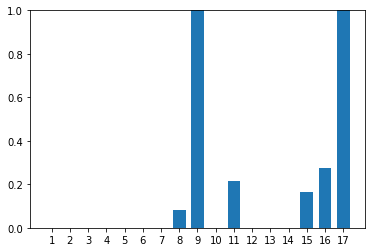

[0, 0, 0.1162587096056639, 0, 0, 0.2540085958053851, 0, 0, 0, 0, 0, 0.12598113069083597, 0.998423323324282, 1, 1, 0, 0.5151926940810498]


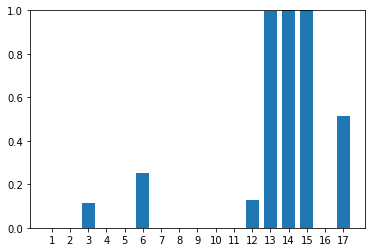

In [118]:
import matplotlib.pyplot as plt

def sdgList(predictions, threshold):
    sdgTrue = 17*[0]
    for i in range(17):
        if predictions[i] > 1:
            sdgTrue[i] = 1
        elif predictions[i] - threshold > 0:
            sdgTrue[i] = (predictions[i] - threshold) / (1 - threshold)
        else:
            sdgTrue[i] = 0
    return sdgTrue
sdgNames = []
for i in range(17):
    sdgNames.append(i+1)
for doku in sdgPredictions:
    print(sdgList(doku, 0.8))
    plt.figure()
    plt.ylim([0,1])
    plt.bar(sdgNames, sdgList(doku, 0.8), 0.7)
    plt.xticks(sdgNames)
    plt.show()
